In [1]:
import joblib
import pandas as pd
import category_encoders as ce
from xgboost import XGBClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

C:\Users\guram\AppData\Local\Temp\ipykernel_2092\1506161809.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv("../Data/fraud_0.1origbase.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,283,CASH_IN,210329.84,C1159819632,3778062.79,3988392.64,C1218876138,1519266.60,1308936.76,0,0
1,132,CASH_OUT,215489.19,C1372369468,21518.00,0.00,C467105520,6345756.55,6794954.89,0,0
2,355,DEBIT,4431.05,C1059822709,20674.00,16242.95,C76588246,80876.56,85307.61,0,0
3,135,CASH_OUT,214026.20,C1464960643,46909.73,0.00,C1059379810,13467450.36,13681476.56,0,0
4,381,CASH_OUT,8858.45,C831134427,0.00,0.00,C579876929,1667180.58,1676039.03,0,0


##### GENERAL LOGIC

In [3]:
df.loc[( (df['type']=='TRANSFER') | (df['type']=='CASH_OUT')) ,'newbalanceOrig'] = df['oldbalanceOrg'] - df['amount']
df.loc[( (df['type']=='TRANSFER') | (df['type']=='CASH_OUT')) ,'newbalanceDest'] = df['oldbalanceDest'] + df['amount']

In [4]:
# step-ების დღეებად და საათებად გადაკეთება
df['hours'] = df['step'] % 24 
df['days'] = df['step'] // 24
# ახალი ცვლადის შექმნა რომელსაც ვანიჭებთ არის თუ არა amount ნაკლები oldbalanceOrg-ზე
df['isAmountLess'] = ((df['amount']<df['oldbalanceOrg']) & ((df['type']=="CASH_OUT")|(df['type']=='TRANSFER')|(df['type']=='DEBIT')|(df['type']=='PAYMENT'))).astype(int)
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hours,days,isAmountLess
0,283,CASH_IN,210329.84,C1159819632,3778062.79,3988392.64,C1218876138,1519266.60,1308936.76,0,0,19,11,0
1,132,CASH_OUT,215489.19,C1372369468,21518.00,-193971.19,C467105520,6345756.55,6561245.74,0,0,12,5,0
2,355,DEBIT,4431.05,C1059822709,20674.00,16242.95,C76588246,80876.56,85307.61,0,0,19,14,1
3,135,CASH_OUT,214026.20,C1464960643,46909.73,-167116.47,C1059379810,13467450.36,13681476.56,0,0,15,5,0
4,381,CASH_OUT,8858.45,C831134427,0.00,-8858.45,C579876929,1667180.58,1676039.03,0,0,21,15,0


#### GET TARGET

In [5]:
# გამოვყოთ target დანარჩენი მონაცემებისგან
X = df.drop(columns=["isFraud"])
Y = df['isFraud'].copy()

#### Split Data

In [6]:
# დავსპლიტოთ მონაცემები 20% Train და 80% Test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [7]:
# გავუკეთოთ encoding რადგან მოდელმა შეძლოს მისი წაკითხვა
woe_encoder = ce.WOEEncoder(cols=['type','nameOrig','nameDest'])
X_train_encoded = woe_encoder.fit_transform(X_train,Y_train)
X_test_encoded = woe_encoder.transform(X_test)

In [8]:
# დავათრეინოთ მოდელი რათა შეისწავლოს train მონაცემები
xgb_model = XGBClassifier()
xgb_model.fit(X_train_encoded, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [10]:
# მონაცემების შენახვა
joblib.dump(xgb_model,"../Model/xgb_model_saved.joblib")

['../Model/xgb_model_saved.joblib']

In [ ]:
# ჩამოვტვირთოთ მონაცემები
xgb_model = joblib.load("../Model/xgb_model_saved.joblib")

In [ ]:
# გავაკეთოთ ფრედიქშენი
y_pred = xgb_model.predict_proba(X_test_encoded)[:,1]


In [ ]:
thresholds = [k/100 for k in range(0,100,1)]
best_threshold = 0
best_auc = 0
for threshold in thresholds:
    y_pred_binary = (y_pred > threshold).astype(int)
    auc = roc_auc_score(Y_test, y_pred_binary)
    if auc > best_auc:
        best_auc = auc
        best_threshold = threshold
print(best_threshold)

0.66


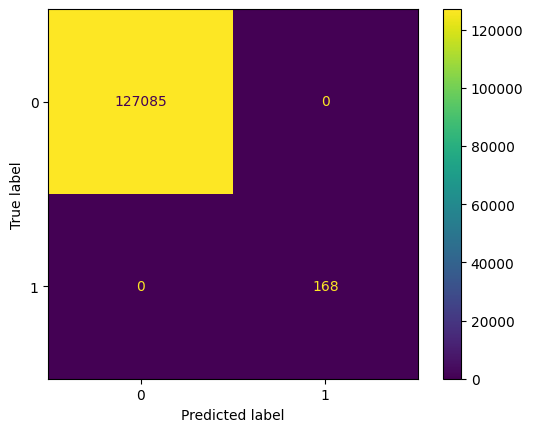

In [ ]:

# გამოვსახოთ Confusion მატრიცა
conf_matrix = metrics.confusion_matrix(Y_test, (y_pred > best_threshold).astype(int))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])
cm_display.plot()
plt.show()

In [ ]:
X_test['predicted_label'] = (y_pred > 0.5).astype(int)

In [ ]:
misclassified_data = X_test[X_test['predicted_label']!=Y_test]
misclassified_data.loc[misclassified_data['predicted_label']==0].head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud,hours,days,isAmountLess,predicted_label
